In [81]:
setwd("~/Bureau") #setting the envoronment

In [85]:
monthly = read.csv('MONTHLY_CHIRP_KIR_MUY_AGREG2.csv')


In [86]:
library(spi)
require(SPEI)

In [87]:
spi = spi(monthly$CHIRP_KIR, scale = 1, distribution = 'Gamma')

In [88]:
spi

            Jan          Feb          Mar          Apr          May
1   0.242713671  0.066112680 -0.669150033  2.659499199 -0.112334573
2   0.412224428  0.241767669  0.599141423 -0.433414388  0.870632355
3   1.043998366 -0.217823847  0.254634667  1.826454421 -1.202192964
4  -0.214139617  0.555297253 -0.025983809 -0.341122206  0.004542548
5  -0.350250280  1.868923804 -0.101388459  0.010664135 -0.197906727
6  -0.440663143 -0.049480165 -0.353769892 -0.171645393  1.662155873
7  -1.502061093 -0.638144839 -1.136788353  0.821326865 -0.291118801
8   1.732900075  0.130764700 -0.136304136 -0.281221429  0.308170718
9   0.194286135  0.029904707  0.709571566 -0.255352771  0.741920786
10 -0.385653716  0.317027917 -1.089725705  0.248751051  0.307205685
11 -0.545608146  0.525564272  0.189989662 -0.879361825 -1.258975279
12  1.207928739 -1.201513202  0.077681109  1.338490588  0.911177514
13  2.281878207  1.107958777  1.869761397 -0.028481884  0.553565399
14 -0.214334744 -2.680403105  1.708150878 -1.654

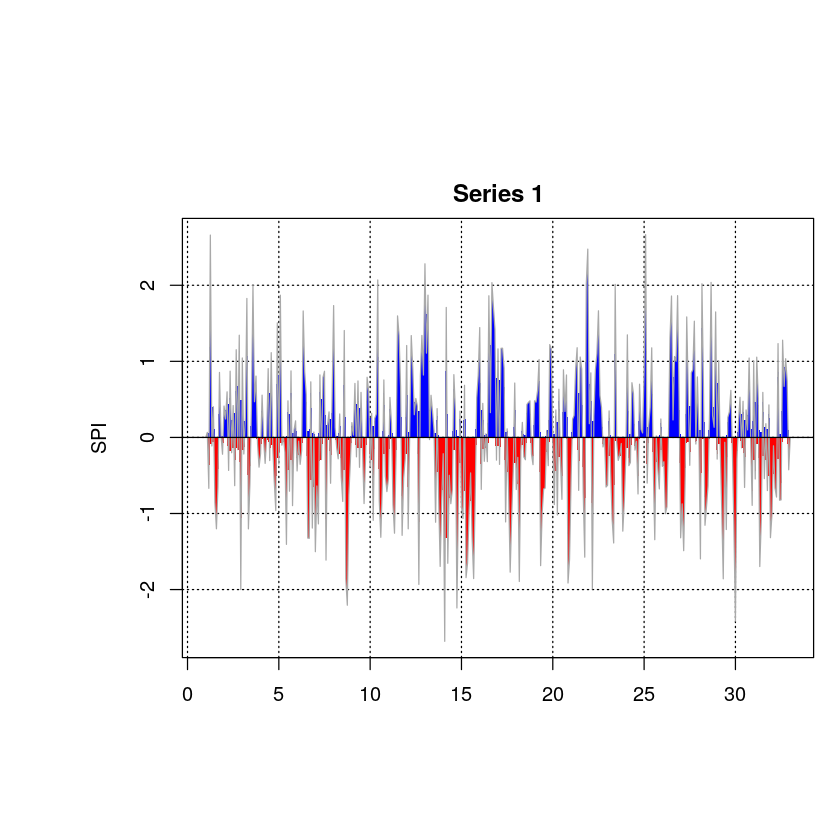

In [89]:
par(fig=c(0.1,1,0.1,0.8))
plot(spi)

In [90]:
summary(spi)

Call:
spi(data = monthly$CHIRP_KIR, scale = 1, distribution = "Gamma")

Coefficients:
	Series 1:
        alpha      beta
1  10.9154572  8.256786
2   8.1099249 10.945061
3  21.2584569  6.660070
4  13.7346441 12.431533
5   6.9327195 13.487267
6   2.1215673  5.992106
7   0.8093582  4.149082
8   2.8535969  7.694401
9   6.9339716  8.436110
10 17.9473099  6.384024
11 17.6491683  8.014806
12 10.2561496 10.090196

Fitted:
            Jan          Feb          Mar          Apr          May
1   0.242713671  0.066112680 -0.669150033  2.659499199 -0.112334573
2   0.412224428  0.241767669  0.599141423 -0.433414388  0.870632355
3   1.043998366 -0.217823847  0.254634667  1.826454421 -1.202192964
4  -0.214139617  0.555297253 -0.025983809 -0.341122206  0.004542548
5  -0.350250280  1.868923804 -0.101388459  0.010664135 -0.197906727
6  -0.440663143 -0.049480165 -0.353769892 -0.171645393  1.662155873
7  -1.502061093 -0.638144839 -1.136788353  0.821326865 -0.291118801
8   1.732900075  0.130764700 -0.136304

jpeg 
   3

png 
  2

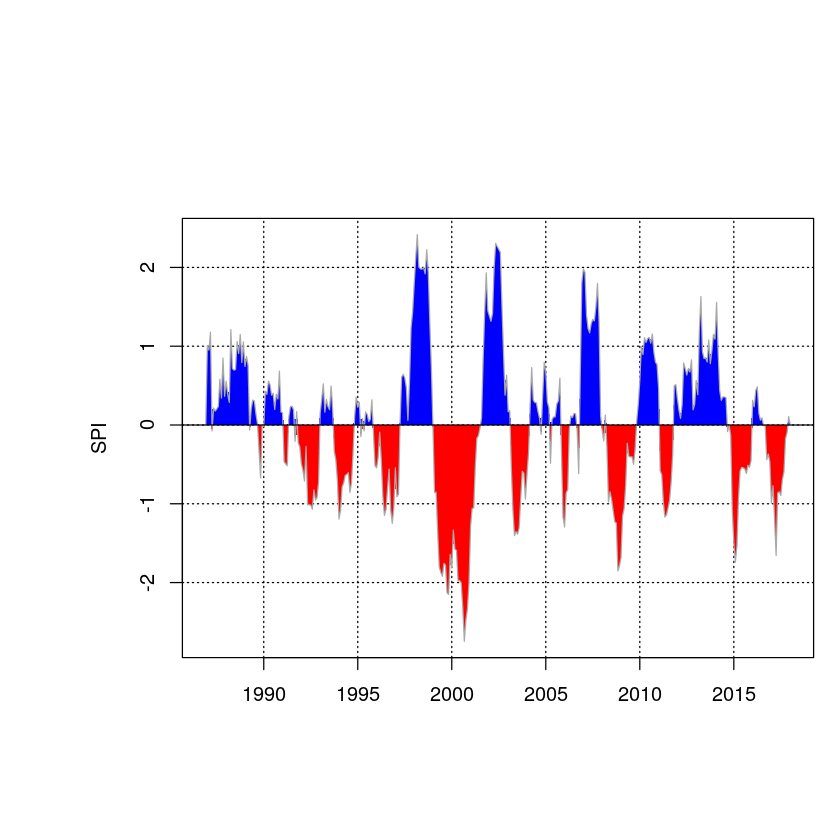

In [91]:
par(fig=c(0.1,1,0.1,0.8))
plot(spi(ts(monthly$CHIRP_KIR,freq=12,start=c(1986,1)),scale = 12), main = '', ylab = 'Standardized Precipitation Index')
dev.copy(jpeg,'SPI.jpeg')
dev.off()

In [92]:
# extract  paramaters.
PARA = data.frame(spi$coefficients)
PARA

,Series.1.1,Series.1.2,Series.1.3,Series.1.4,Series.1.5,Series.1.6,Series.1.7,Series.1.8,Series.1.9,Series.1.10,Series.1.11,Series.1.12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,10.915457,8.109925,21.25846,13.73464,6.93272,2.121567,0.8093582,2.853597,6.933972,17.947310,17.649168,10.25615
beta,8.256786,10.945061,6.66007,12.43153,13.48727,5.992106,4.1490821,7.694401,8.436110,6.384024,8.014806,10.09020


In [93]:
# Accumulated Rainfall for 3-month SPI
PRCP3 = rowSums(embed(monthly$CHIRP_KIR,3),na.rm=FALSE)
# Adding year and month to data fram PRCP3
PRCP3 = data.frame(monthly$Date[3:nrow(monthly)], monthly$MONTH[3:nrow(monthly)],PRCP3)
# Change the colunm names
colnames(PRCP3) = c("year", "month", "accumulatedPre")
# Calculate p value for each month
KSTest = function(X, Para, MON){
  Ecdf = ecdf(X)
  Fempirical = Ecdf(X)
  ## Extract Gamma parameter
  a = Para[1]
  b = Para[2]
  Ftheory = mat.or.vec(length(X),1)
  for (i in 1:length(X)){
    x = X[i]
    xf <- function(t,A,B) { t^(A-1)*exp(-t/B) }
    # compute the integral
    Q  <- integrate(xf,0,x,A=a,B=b)
    Ftheory[i] <- Q$val*b^(-a)/gamma(a)
  }
  # Kolmogorov - Sminov Test, jitter function used to avoid 
  # a possible warning: "In ks.test(Ftheory, Fempirical) : cannot compute exact p-value with ties
  KSTest = ks.test(jitter(Ftheory), jitter(Fempirical))
  pval = KSTest$p.value
  print(paste("---p-value for ", MON," is: ", pval,sep = ""))
  # create matrix for furthur plot 
  Fall = data.frame(X,Fempirical,Ftheory)
  return(Fall)
}
#Determine total length of timeseries X for all months
t = 0
for (iM in 1:12){
    X = subset(PRCP3, PRCP3$month == iM)[,3]
    t = t+length(X)
}
FMain = mat.or.vec(t,3)
MONLabel = mat.or.vec(t,1)
monthnames = c("Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul","Aug","Sept","Oct", "Nov", "Dec")
t1 = 0; t2 = 0; #set index to save acummulated timeseries X, empirical cumulative function, theoretical cumulative function
for (iM in 1:12){
  X = subset(PRCP3, PRCP3$month == iM)[,3]
  t1 = t2 +1  # set lower bound index
  t2 = t2 + length(X) #set upper bound index
  Para = PARA[,iM] #extract parameter according to iM month
  MON = monthnames[iM] #extract the month's name 
  FMain[t1:t2,]= as.matrix(KSTest(X, Para, MON))
  MONLabel[t1:t2] = rep(MON,length(X))
  if (iM == 12){
    print("Finish Kolmogorov Smirnov test")
    print("Null hypothesis: both distributions follow the same distribution")
    print("A p-value is less than 0.05 means a rejection of this null hypothesis")
  }
}

[1] "---p-value for Jan is: 2.39708253246818e-12"
[1] "---p-value for Feb is: 2.78064238301567e-11"
[1] "---p-value for Mar is: 8.32112156956555e-12"
[1] "---p-value for Apr is: 8.32112156956555e-12"
[1] "---p-value for May is: 2.22044604925031e-16"
[1] "---p-value for Jun is: 2.22044604925031e-16"
[1] "---p-value for Jul is: 2.22044604925031e-16"
[1] "---p-value for Aug is: 0.000174088069996525"
[1] "---p-value for Sept is: 0.00393063554049955"
[1] "---p-value for Oct is: 6.77953027050648e-10"
[1] "---p-value for Nov is: 2.44249065417534e-15"
[1] "---p-value for Dec is: 2.22044604925031e-16"
[1] "Finish Kolmogorov Smirnov test"
[1] "Null hypothesis: both distributions follow the same distribution"
[1] "A p-value is less than 0.05 means a rejection of this null hypothesis"


In [94]:
FMain = data.frame(FMain, MONLabel)
# change file names for FMain
colnames(FMain)  =c("X","Fempirical", "Ftheory","MONLabel")
# change order to display in ggplot2
order = monthnames
library("plyr")
dat <- arrange(transform(FMain,MONLabel=factor(MONLabel,levels=order)),MONLabel)
# plot empirical and theoretical  cumulative for all months in a same figure
    textSize = 8 # set text size for axis title and axis label
    require(ggplot2)

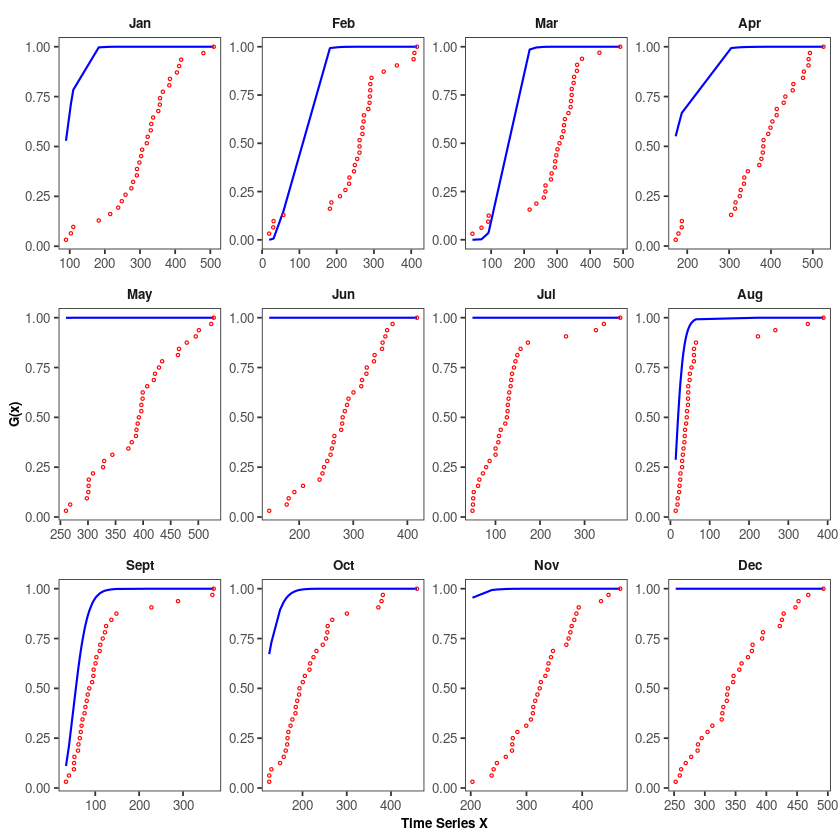

In [95]:
 ggplot()+
    geom_line(data = dat,aes(x = X, y = Ftheory),size = 0.6, colour = "blue")+
    geom_point(data = dat, aes(x = X, y = Fempirical),size =0.6,shape = 1, colour = "red")+
    facet_wrap(~MONLabel, scales = "free")+
    ylab("G(x)")+
    xlab("Time Series X")+
    theme_bw()+
    theme(  axis.text.x = element_text(size=textSize),
            axis.title.x = element_text(face = "bold",size = textSize),
            axis.text.y = element_text(size=textSize),
            axis.title.y = element_text(face = "bold",size = textSize),
            legend.position = "none",
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            strip.background = element_blank(),
            strip.text = element_text(size = textSize, face = "bold"))